In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge, RidgeCV, Lasso, LassoCV
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import r2_score
import itertools
import time
import statsmodels.formula.api as sm

train = pd.read_csv('ncaa_train.csv')
test = pd.read_csv('ncaa_test.csv')

## Data quality check / cleaning / preparation 

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.** An example is given below.

### Data quality check
*By Srikrishna Sorna*

The code below visualizes the distribution of all the variables in the dataset, and their association with the response.

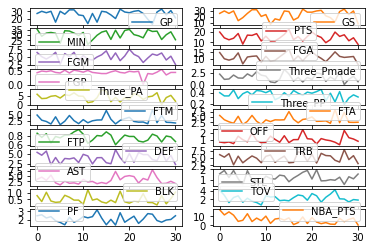

In [2]:
#...Distribution of continuous variables...#
import pandas as pd
import matplotlib.pyplot as plt
train = pd.read_csv('ncaa_train.csv')
train.plot(subplots=True, layout=(11,2))
plt.show()

The Mean of the response variable is 6.580967741935483
The Standard Deviation of the response variable is 4.291996703042155


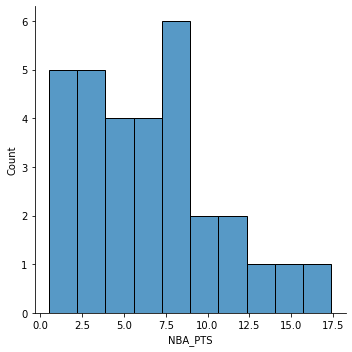

In [9]:
#...Distribution of response variable in training data...#
# Showcasing the mean and standard deviation of NBA_PTS of training data
sns.displot(train, x="NBA_PTS", bins = 10)
print("The Mean of the response variable is",train.NBA_PTS.mean())
print("The Standard Deviation of the response variable is",train.NBA_PTS.std())

### Data cleaning
*By Srikrishna Sorna and Neal Agarwal*

From the data quality check we realized that:

1. Some of the columns that should have contained only numeric values, specifically <>, <>, and <> have special characters such as \*, #, %. We'll remove these characters, and convert the datatype of these columns to numeric.

2. Some of the columns have more than 60% missing values, and it is very difficult to impute their values, as the values seem to be missing at random with negligible association with other predictors. We'll remove such columns from the data.

3. The column `number_of_bedrooms` has some unreasonably high values such as 15. As our data consist of single-family homes in Evanston, we suspect that any value greater than 5 may be incorrect. We'll replace all values that are greater than 5 with an estimate obtained using the $K$-nearest neighbor approach.

4. The columns `house_price` has some unreasonably high values. We'll tag all values greater than 1 billion dollars as "potentially incorrect observation", to see if they distort our prediction / inference later on.

The code below implements the above cleaning.

In [10]:
#...Code with comments...#

### Data preparation
*By Sankaranarayanan Balasubramanian and Chun-Li*

The following data preparation steps helped us to prepare our data for implementing various modeling / validation techniques:

1. Since we need to predict house price, we derived some new predictors *(from existing predictors)* that intuitively seem to be helpuful to predict house price. 

2. We have shuffled the dataset to prepare it for K-fold cross validation.

3. We have created a standardized version of the dataset, as we will use it to develop Lasso / Ridge regression models.

In [11]:
######---------------Creating new predictors----------------#########

#Creating number of bedrooms per unit floor area

#Creating ratio of bathrooms to bedrooms

#Creating ratio of carpet area to floor area

In [12]:
######-----------Shuffling the dataset for K-fold------------#########

In [13]:
######-----Standardizing the dataset for Lasso / Ridge-------#########

## Exploratory data analysis

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Correlation and VIF Tables by Emily Chan

In [14]:
train.corr()['NBA_PTS'].sort_values(ascending=False)

NBA_PTS        1.000000
GS             0.433931
FTP            0.351406
GP             0.337517
MIN            0.323561
STL            0.318212
FGM            0.270299
Three_Pmade    0.260686
PTS            0.249359
Three_PA       0.245180
DEF            0.228423
FGP            0.200565
FGA            0.191621
Three_PP       0.118538
BLK            0.104205
TRB            0.101691
PF             0.090852
TOV            0.073663
FTM            0.053743
AST           -0.007441
FTA           -0.015898
OFF           -0.241982
Name: NBA_PTS, dtype: float64

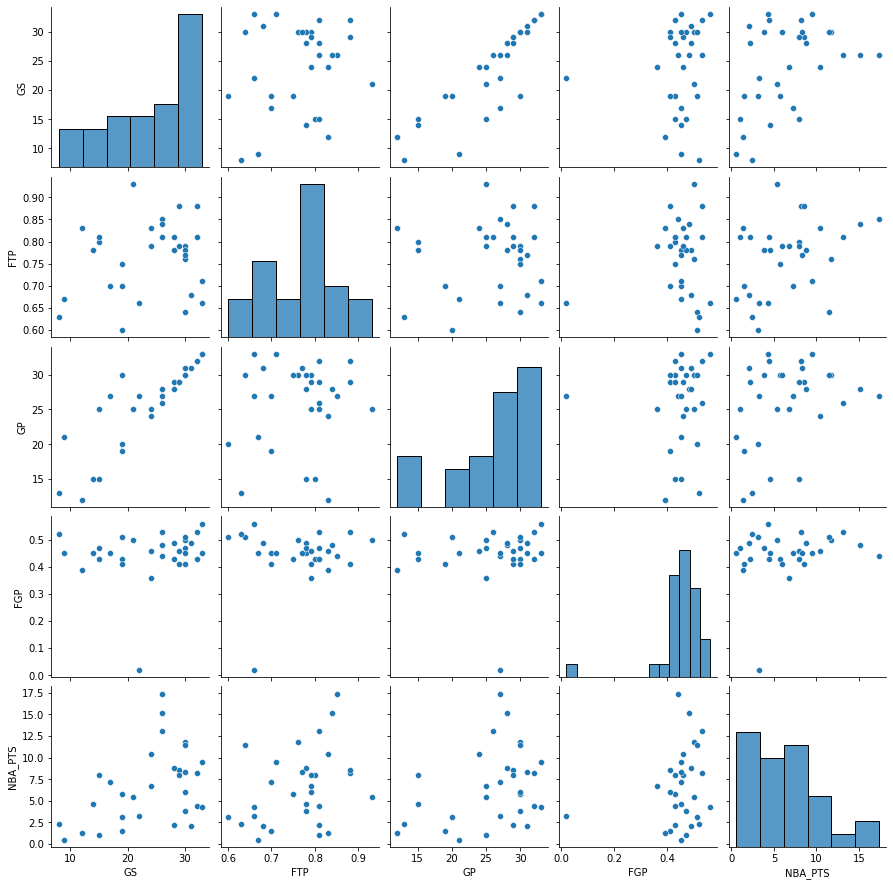

In [15]:
top4 = train[['GS','FTP','GP','FGP','NBA_PTS']]
sns.pairplot(top4)

In [43]:
#VIF table starting with all predictors and removing one-by-one until all <5
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
X = train[['GS', 'MIN', 'FGP','Three_PA', 'Three_PP', 'FTA', 'FTP', 'OFF', 'DEF', 'AST','STL', 'BLK', 'TOV', 'PF']]
X = add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns

for i in range(len(X.columns)):
    vif_data.loc[i,'VIF'] = variance_inflation_factor(X.values, i)

print(vif_data)

     feature         VIF
0      const  294.702398
1         GS    1.850221
2        MIN    3.732064
3        FGP    1.509959
4   Three_PA    3.387936
5   Three_PP    2.724658
6        FTA    3.472252
7        FTP    2.501875
8        OFF    2.318019
9        DEF    1.977811
10       AST    3.230762
11       STL    2.317251
12       BLK    2.074200
13       TOV    3.929724
14        PF    1.658651


### Base Model with All Predictors by Pranav Doradla

In [16]:
model1 = sm.ols(formula = 'NBA_PTS~GS+FTP+GP+MIN+STL+FGM+Three_Pmade+PTS+DEF+FGP+FGA+BLK+TRB+PF+TOV+AST+FTA+OFF+Three_PP+Three_PA', data=train).fit()
model1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.197
Method:                 Least Squares   F-statistic:                     1.368
Date:                Sun, 12 Mar 2023   Prob (F-statistic):              0.312
Time:                        21:36:33   Log-Likelihood:                -68.205
No. Observations:                  31   AIC:                             178.4
Df Residuals:                      10   BIC:                             208.5
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      24.5531     54.712      0.449      0.663     -97.353     146.459
GS              0.3822      0.457      0.836      0.422      -0.636       1.400
FTP           -16.7203     36.769     -0.455      0.659     -98.646      65.206
GP             -0.0191      0.510     -0.037      0.971      -1.155       1.117
MIN            -0.1806      0.448     -0.403      0.695      -1.179       0.818
STL             1.8960      2.957      0.641      0.536      -4.692       8.484
FGM           -31.1965     30.714     -1.016      0.334     -99.632      37.239
Three_Pmade   -13.4931      9.828     -1.373      0.200     -35.392       8.406
PTS            16.3161     15.864      1.029      0.328     -19.030      51.662
DEF           -28.3527    164.569     -0.172      0.867    -395.036     338.331
FGP            10.9439     14.203      0.771      0.459     -20.701      42.589
FGA            -0.2702      1.759     -0.154      0.881      -4.189       3.648
BLK             3.3331      4.434      0.752      0.470      -6.548      13.214
TRB            29.1618    164.638      0.177      0.863    -337.675     395.999
PF              0.0109      3.025      0.004      0.997      -6.728       6.750
TOV             2.4447      2.238      1.092      0.300      -2.543       7.432
AST            -0.7914      0.801     -0.988      0.346      -2.576       0.993
FTA           -14.5552     12.961     -1.123      0.288     -43.435      14.324
OFF           -31.0310    164.681     -0.188      0.854    -397.963     335.901
Three_PP      -45.5084     50.228     -0.906      0.386    -157.424      66.407
Three_PA       -1.5783      5.505     -0.287      0.780     -13.845      10.689
==============================================================================
Omnibus:                        3.100   Durbin-Watson:                   1.514
Prob(Omnibus):                  0.212   Jarque-Bera (JB):                1.792
Skew:                          -0.314   Prob(JB):                        0.408
Kurtosis:                       3.996   Cond. No.                     2.16e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.16e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [17]:
preds1 = model1.predict(test)
actuals = test[['NBA_PTS']]
actuals = actuals.iloc[:,0]
print('RMSE = ', np.sqrt(((preds1 - actuals)**2).mean()),'resid. standard error = ',np.sqrt(model1.mse_resid))

RMSE =  7.0380521721926215 resid. standard error =  3.845568228666777


Text(0, 0.5, 'Residuals')

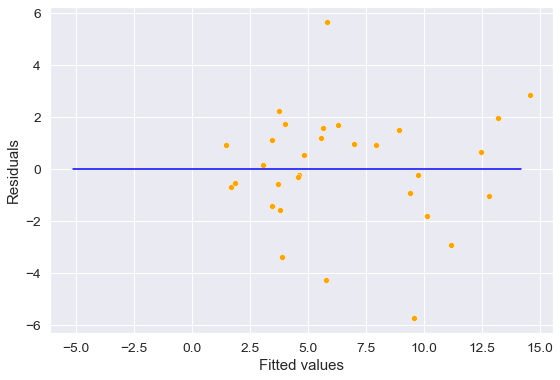

In [18]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model1.fittedvalues, y=model1.resid,color = 'orange')
sns.lineplot(x = [preds1.min(),preds1.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

## Developing the model

Put code with comments. The comments should explain the code such that it can be easily understood. You may put text *(in a markdown cell)* before a large chunk of code to explain the overall purpose of the code, if it is not intuitive. **Put the name of the person / persons who contributed to each code chunk / set of code chunks.**

### Initial MLR Model by Emily Chan

In [44]:
#Model 2 MLR
model2 = sm.ols(formula = 'np.log(NBA_PTS)~GS+GP+FTP+FGP+I(GS**2)+I(GP**2)+I(FGP**2)', data=train).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        np.log(NBA_PTS)   R-squared:                       0.498
Model:                            OLS   Adj. R-squared:                  0.345
Method:                 Least Squares   F-statistic:                     3.256
Date:                Sun, 12 Mar 2023   Prob (F-statistic):             0.0149
Time:                        21:50:41   Log-Likelihood:                -27.736
No. Observations:                  31   AIC:                             71.47
Df Residuals:                      23   BIC:                             82.94
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.2269      2.298     -0.969      0.343      -6.980       2.526
GS              0.4347      0.174      2.502      0.020       0.075       0.794
GP             -0.2512      0.256     -0.982      0.336      -0.781       0.278
FTP             1.6106      1.815      0.887      0.384      -2.144       5.365
FGP            -1.7620      4.972     -0.354      0.726     -12.047       8.523
I(GS ** 2)     -0.0086      0.004     -2.040      0.053      -0.017       0.000
I(GP ** 2)      0.0051      0.006      0.864      0.397      -0.007       0.017
I(FGP ** 2)     6.1480      7.994      0.769      0.450     -10.389      22.685
==============================================================================
Omnibus:                        2.965   Durbin-Watson:                   2.277
Prob(Omnibus):                  0.227   Jarque-Bera (JB):                2.201
Skew:                          -0.492   Prob(JB):                        0.333
Kurtosis:                       2.143   Cond. No.                     7.79e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.79e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
#Model 2 RMSE
preds2 = model2.predict(test)
actuals = test[['NBA_PTS']]
actuals = actuals.iloc[:,0]
print('RMSE = ', np.sqrt(((preds2 - actuals)**2).mean()),'resid. standard error = ',np.sqrt(model2.mse_resid))

RMSE =  7.315852743977313 resid. standard error =  0.6872999485748479


Text(0, 0.5, 'Residuals')

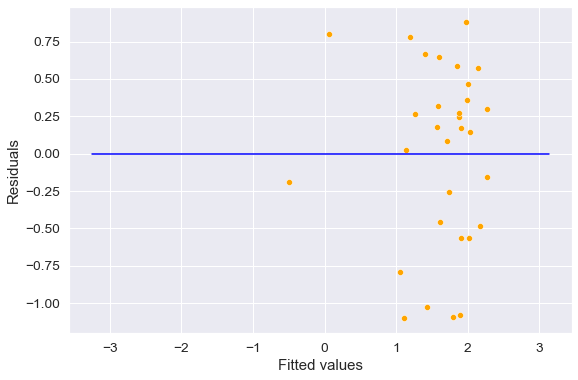

In [46]:
#Plotting residuals vs fitted values
plt.rcParams["figure.figsize"] = (9,6)
sns.set(font_scale=1.25)
ax = sns.scatterplot(x = model2.fittedvalues, y=model2.resid,color = 'orange')
sns.lineplot(x = [preds2.min(),preds2.max()],y = [0,0],color = 'blue')
plt.xlabel('Fitted values')
plt.ylabel('Residuals')

### Forward Stepwise Selection by Emily Chan

In [19]:
#Forward Stepwise Selection
#Creating a set of predictors from which we need to find the best subset of predictors
X = train[['GS', 'MIN', 'FGP',
       'Three_PA', 'Three_PP', 'FTA', 'FTP', 'OFF', 'DEF', 'AST',
       'STL', 'BLK', 'TOV', 'PF']]
#Function to develop a model based on all predictors in predictor_subset
def processSubset(predictor_subset):
    # Fit model on feature_set and calculate R-squared
    model = sm.ols('NBA_PTS~' + '+'.join(predictor_subset),data = train).fit()
    Rsquared = model.rsquared
    return {"model":model, "Rsquared":Rsquared}
#Function to find the best predictor out of p-k predictors and add it to the model containing the k predictors
def forward(predictors):

    # Pull out predictors we still need to process
    remaining_predictors = [p for p in X.columns if p not in predictors]
    
    tic = time.time()
    
    results = []
    
    for p in remaining_predictors:
        results.append(processSubset(predictors+[p]))
    
    # Wrap everything up in a nice dataframe
    models = pd.DataFrame(results)
    
    # Choose the model with the highest RSS
    best_model = models.loc[models['Rsquared'].argmax()]
    
    toc = time.time()
    print("Processed ", models.shape[0], "models on", len(predictors)+1, "predictors in", (toc-tic), "seconds.")
    
    # Return the best model, along with some other useful information about the model
    return best_model
def forward_selection():
    models_best = pd.DataFrame(columns=["Rsquared", "model"])

    tic = time.time()
    predictors = []

    for i in range(1,len(X.columns)+1):    
        models_best.loc[i] = forward(predictors)
        predictors = list(models_best.loc[i]["model"].params.index[1:])

    toc = time.time()
    print("Total elapsed time:", (toc-tic), "seconds.")
    return models_best
models_best = forward_selection()

Processed  14 models on 1 predictors in 0.06856012344360352 seconds.
Processed  13 models on 2 predictors in 0.07094717025756836 seconds.
Processed  12 models on 3 predictors in 0.06885600090026855 seconds.
Processed  11 models on 4 predictors in 0.08640003204345703 seconds.
Processed  10 models on 5 predictors in 0.08223485946655273 seconds.
Processed  9 models on 6 predictors in 0.07901716232299805 seconds.
Processed  8 models on 7 predictors in 0.08034801483154297 seconds.
Processed  7 models on 8 predictors in 0.07259535789489746 seconds.
Processed  6 models on 9 predictors in 0.0712740421295166 seconds.
Processed  5 models on 10 predictors in 0.0754098892211914 seconds.
Processed  4 models on 11 predictors in 0.05676889419555664 seconds.
Processed  3 models on 12 predictors in 0.0429997444152832 seconds.
Processed  2 models on 13 predictors in 0.03280210494995117 seconds.
Processed  1 models on 14 predictors in 0.017315149307250977 seconds.
Total elapsed time: 0.9403252601623535 s

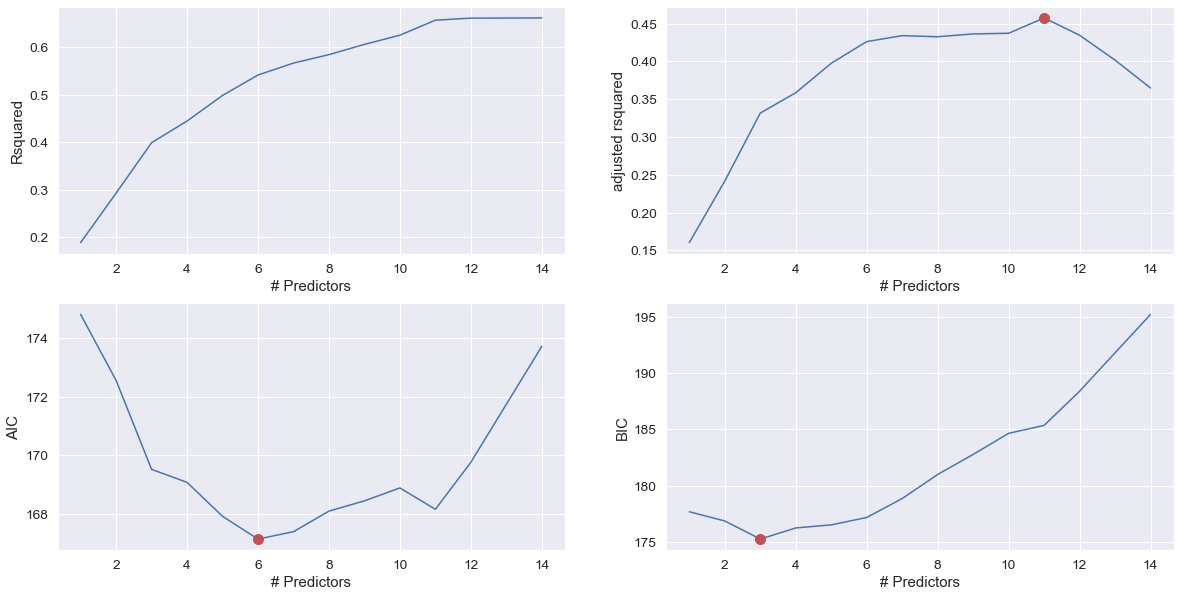

In [20]:
def best_sub_plots():
    plt.figure(figsize=(20,10))
    plt.rcParams.update({'font.size': 18, 'lines.markersize': 10})

    # Set up a 2x2 grid so we can look at 4 plots at once
    plt.subplot(2, 2, 1)

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector
    plt.plot(models_best["Rsquared"])
    plt.xlabel('# Predictors')
    plt.ylabel('Rsquared')

    # We will now plot a red dot to indicate the model with the largest adjusted R^2 statistic.
    # The argmax() function can be used to identify the location of the maximum point of a vector

    rsquared_adj = models_best.apply(lambda row: row[1].rsquared_adj, axis=1)

    plt.subplot(2, 2, 2)
    plt.plot(rsquared_adj)
    plt.plot(1+rsquared_adj.argmax(), rsquared_adj.max(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('adjusted rsquared')

    # We'll do the same for AIC and BIC, this time looking for the models with the SMALLEST statistic
    aic = models_best.apply(lambda row: row[1].aic, axis=1)

    plt.subplot(2, 2, 3)
    plt.plot(aic)
    plt.plot(1+aic.argmin(), aic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('AIC')

    bic = models_best.apply(lambda row: row[1].bic, axis=1)

    plt.subplot(2, 2, 4)
    plt.plot(bic)
    plt.plot(1+bic.argmin(), bic.min(), "or")
    plt.xlabel('# Predictors')
    plt.ylabel('BIC')
best_sub_plots()

In [21]:
best_fwd_reg_model = models_best['model'][6]
best_fwd_reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.541
Model:                            OLS   Adj. R-squared:                  0.426
Method:                 Least Squares   F-statistic:                     4.716
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00265
Time:                        21:36:37   Log-Likelihood:                -76.565
No. Observations:                  31   AIC:                             167.1
Df Residuals:                      24   BIC:                             177.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -12.5679      7.889     -1.593      0.124     -28.850       3.714
GS             0.3614      0.091      3.972      0.001       0.174       0.549
OFF           -3.9649      1.429     -2.774      0.011      -6.915      -1.015
BLK            5.0575      2.115      2.391      0.025       0.692       9.423
FTP           11.7793      8.635      1.364      0.185      -6.043      29.602
TOV            2.4482      1.089      2.249      0.034       0.201       4.695
AST           -0.7967      0.531     -1.500      0.147      -1.893       0.300
==============================================================================
Omnibus:                        1.154   Durbin-Watson:                   1.141
Prob(Omnibus):                  0.562   Jarque-Bera (JB):                1.088
Skew:                          -0.310   Prob(JB):                        0.580
Kurtosis:                       2.323   Cond. No.                         497.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [22]:
#Forward Stepwise RMSE
preds4 = best_fwd_reg_model.predict(test)
print('RMSE = ', np.sqrt(((preds4 - actuals)**2).mean()))

RMSE =  6.552775041931067


### K-Fold Model Development by Emily Chan

In [23]:
# Creating a dataframe that will consist of all combinations of polynomial transformations of the 
# predictors to be considered for interactions
predictor_set = ['GS', 'OFF','TOV']
from itertools import product
values = np.arange(0,3)
polynomial_transformations = pd.DataFrame(product(values, repeat=3), columns=predictor_set).loc[1:,]
polynomial_transformations.loc[:,'sum_degree'] = (polynomial_transformations).astype(int).sum(axis=1)
polynomial_transformations.loc[:,'count_zeros'] = (polynomial_transformations == 0).astype(int).sum(axis=1)
polynomial_transformations.sort_values(by = ['count_zeros', 'sum_degree'], ascending=[False, True], inplace=True)
polynomial_transformations.drop(columns = ['count_zeros'], inplace=True)
polynomial_transformations.reset_index(inplace = True, drop = True)

#Setting the seed as we are shuffling the data before splitting it into K-folds
np.random.seed(123)
# Shuffling the training set before creating K folds
train = train.sample(frac=1)
k = 5 #5-fold cross validation
fold_size = np.round(train.shape[0]/k)

def KFoldCV(selected_interactions, interaction_being_tested):
    array_new1 = [None]*k
    for i in range(k):
        dropped = np.arange(i*fold_size, (i+1)*fold_size)
        test_new = train.loc[dropped,:]
        train_new = train.drop(dropped)
        model = sm.ols('NBA_PTS~GS+OFF+TOV'+selected_interactions+interaction_being_tested, data = train_new).fit()
        pred = model.predict(test_new)
        array_new1[i] = np.sqrt(((test_new.NBA_PTS - pred)**2).mean())
    return np.mean(array_new1)# mean of array_new1

# This code implements the algorithm of systematically considering interactions of degree 2 and going upto 
# the interaction of degree 12. For a given degree 'd' the interactions are selected greedily based on 
# highest reduction in the 5-fold cross validation RMSE. Once no more reduction in the 5-fold cross validation
# RMSE is possible using interactions of degree 'd', interaction terms of the next higher degree 'd+1' are considered.

# 5-fold cross validation RMSE of the initial model with the 4 predictors of degree one
cv_previous_model = KFoldCV(selected_interactions = '', interaction_being_tested = '')
interaction_being_tested = '+'
selected_interactions = ''

# Considering interactions of degree 'd' = 2 to 12
for d in np.arange(2,13):
    
    # Selecting interaction terms of degree = 'd'
    degree_set = polynomial_transformations.loc[polynomial_transformations.sum_degree==d, :]
    
    # Initializing objects to store the interactions of degree 'd' that reduce the
    # 5-fold cross validation RMSEs as compared to the previous model
    interactions_that_reduce_KfoldCV = []; cv_degree = []; 
    
    # Creating another DataFrame that will consist of the updated set of interactions of degree 'd' to be considered
    # as interactions that do not reduce the 5-fold cross validation RMSE will be discarded
    degree_set_updated = pd.DataFrame(columns = degree_set.columns)
    
    # Continue adding interactions of degree 'd' in the model until no interactions reduce 
    # the 5-fold cross-validation RMSE
    while True:
        
        #Iterating over all possible interactions of degree 'd'
        for index, row in degree_set.iterrows():
            
            # Creating the formula expression for the interaction term to be tested
            for predictor in predictor_set:
                interaction_being_tested = interaction_being_tested + ('I('+predictor +'**' +\
                                         str(row[predictor]) + ')*' if row[predictor]>1 else\
                                               predictor + '*' if row[predictor]==1 else '')
            interaction_being_tested = interaction_being_tested[:-1]
            
            # Call the function 'KFoldCV' to find out the 5-fold cross validation error on adding the 
            # interaction term being tested to the model
            cv = KFoldCV(selected_interactions, interaction_being_tested)
            
            # If the interaction term being tested reduces the 5-fold cross validation RMSE as compared to the
            # previous model, then consider adding it to the model
            if cv<cv_previous_model:
                interactions_that_reduce_KfoldCV.append(interaction_being_tested)
                cv_degree.append(cv)
                degree_set_updated = pd.concat([degree_set_updated, row.to_frame().T])
            interaction_being_tested = '+'
        cv_data = pd.DataFrame({'interaction':interactions_that_reduce_KfoldCV, 'cv':cv_degree})
        
        # Sort the interaction terms that reduce the 5-fold cross valdiation RMSE based on their respective
        # 5-fold cross validation RMSE
        cv_data.sort_values(by = 'cv', inplace = True)
        
        # Break the loop if no interaction of degree 'd' reduces the 5-fold cross validation RMSE as
        # compared to the previous model
        if cv_data.shape[0]==0:
            break
            
        # Select the interaction that corresponds to the least 5-fold cross validation RMSE
        selected_interactions = selected_interactions + cv_data.iloc[0,0]
        cv_previous_model = cv_data.iloc[0,1]
        cv_degree = []; interactions_that_reduce_KfoldCV = []
        degree_set = degree_set_updated.copy()
        degree_set_updated = pd.DataFrame(columns = degree_set.columns)
        
        # Print the progress after each model update, i.e., after an interaction term is selected
        print("Degree of interactions being considered:",d, ", 5-fold CV RMSE:", cv_previous_model)

Degree of interactions being considered: 2 , 5-fold CV RMSE: 3.742973177180049


In [24]:
selected_interactions

'+GS*TOV'

In [25]:
#  k-fold cv model with selected interactions
kfold_model = sm.ols(formula = 'NBA_PTS~GS+OFF+TOV+GS*TOV', data=train).fit()
kfold_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4.300
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00839
Time:                        21:36:39   Log-Likelihood:                -80.768
No. Observations:                  31   AIC:                             171.5
Df Residuals:                      26   BIC:                             178.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7002      7.446      1.706      0.100      -2.604      28.005
GS            -0.2502      0.307     -0.815      0.422      -0.881       0.381
OFF           -2.3707      1.270     -1.866      0.073      -4.982       0.240
TOV           -4.4396      2.913     -1.524      0.140     -10.427       1.548
GS:TOV         0.2335      0.124      1.888      0.070      -0.021       0.488
==============================================================================
Omnibus:                        1.511   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                0.550
Skew:                           0.219   Prob(JB):                        0.760
Kurtosis:                       3.483   Cond. No.                         779.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [26]:
#K-fold Model RMSE
predsK = kfold_model.predict(test)
actuals = test[['NBA_PTS']]
actuals = actuals.iloc[:,0]
print('RMSE = ', np.sqrt(((predsK - actuals)**2).mean()))

RMSE =  5.8480666275241076


### K-fold Outliers Check and LOOCV Score by Pranav Doradla

In [38]:
#Checking for outliers in K-fold Model
out = kfold_model.outlier_test()
np.sum((np.abs(out.student_resid)>3))

0

In [40]:
#Setting the seed as we are shuffling the data before splitting it into K-folds
np.random.seed(123)
# Shuffling the training set before creating K folds
alldata = pd.concat([train,test])
alldata['indx'] = [i for i in range(61)]
alldata = alldata.set_index(keys=['indx'])
alldata = alldata.sample(frac=1)
k = 60 #5-fold cross validation
fold_size = np.round(alldata.shape[0]/k)

In [41]:
def KFoldCVAllData():
    array_new1 = [None]*k
    for i in range(k):
        dropped = np.arange(i*fold_size, (i+1)*fold_size)
        test_new = alldata.loc[dropped,:]
        train_new = alldata.drop(dropped)
        model = sm.ols('NBA_PTS~GS+OFF+TOV+GS*TOV', data = train_new).fit()
        pred = model.predict(test_new)
        array_new1[i] = np.sqrt(((test_new.NBA_PTS - pred)**2).mean())
    return np.mean(array_new1)# mean of array_new1

In [42]:
KFoldCVAllData()

3.830008257470188

### Lasso Regression by Srikrishna Sorna

(0.0007, 15)

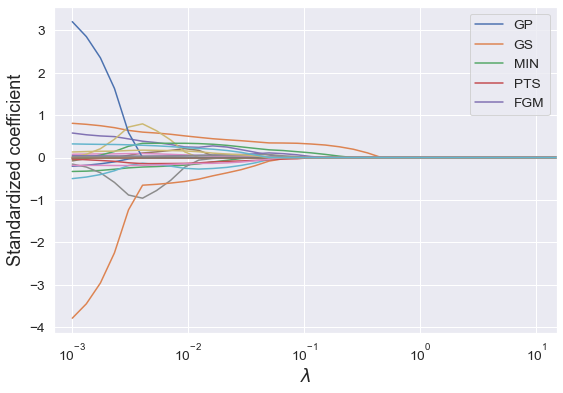

In [27]:
# Taking the log transform of NBA PTS as house prices have a right-skewed distribution
y = np.log(train.NBA_PTS)

# Standardizing predictors so that each of them have zero mean and unit variance
# Filtering all predictors
X = train.iloc[:,1:21];

# Defining a scaler object
scaler = StandardScaler()

# The scaler object will contain the mean and variance of each column (predictor) of X. 
# These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

# Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

# Test dataset
Xtest = test.iloc[:,1:21]

# Standardizing test data
Xtest_std = scaler.transform(Xtest)

# Creating a range of values of the tuning parameter to visualize the lasso coefficients for different values of the tuning parameter
alphas = 10**np.linspace(10,-2,100)*0.1

# Finding the lasso coefficients for increasing values of the tuning parameter
lasso = Lasso(max_iter = 10000)
coefs = []

for a in alphas:
    lasso.set_params(alpha=a)
    lasso.fit(Xstd, y)
    coefs.append(lasso.coef_)

# Visualizing the shrinkage in lasso coefficients with increasing values of the tuning parameter lambda
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(alphas, coefs)
plt.xscale('log')
plt.xlabel('$\lambda$')
plt.ylabel('Standardized coefficient')
plt.legend(train.columns[1:6]);
#plt.plot([lassocv.alpha_,lassocv.alpha_],[-0.4,0.25],':')
plt.legend(train.columns[1:6]);
plt.xlim([0.0007, 15])

In [28]:
# Let us use cross validation to find the optimal value of the tuning parameter - lambda
# For the optimal lambda, the cross validation error will be the least
np.warnings.filterwarnings('ignore')
# Note that we are reducing the range of alpha so as to better visualize the minimum
alphas = 10**np.linspace(-1,-5,200)*0.5
lassocv = LassoCV(alphas = alphas, cv = 10, max_iter = 100000)
lassocv.fit(Xstd, y)

# Optimal value of the tuning parameter - lamda
lassocv.alpha_

0.05

Text(0, 0.5, 'Cross-validation error')

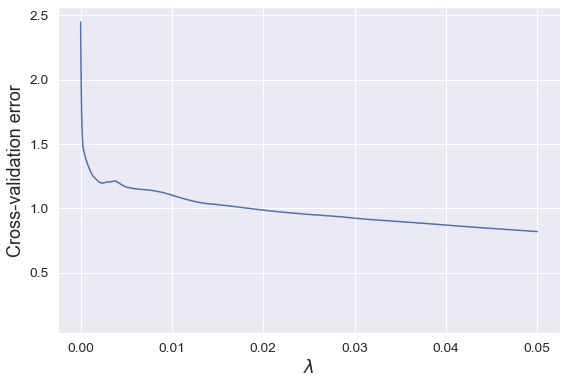

In [29]:
#Visualizing the LOOCV (leave one out cross validatation error vs lambda)
plt.xlabel('xlabel', fontsize=18)
plt.ylabel('ylabel', fontsize=18)
plt.plot(lassocv.alphas_,lassocv.mse_path_.mean(axis=1))
plt.plot([lassocv.alpha_,lassocv.alpha_],[0.145,0.151],':')
plt.xlabel('$\lambda$')
plt.ylabel('Cross-validation error')

In [30]:
# Using the developed lasso model to predict on test data
lasso = Lasso(alpha = lassocv.alpha_)
lasso.fit(Xstd, y)
pred=lasso.predict(Xtest_std)

# RMSE on test data
np.sqrt(((np.exp(pred)-test.NBA_PTS)**2).mean())

5.452917261355154

In [31]:
# R-squared on train data for the lasso model
print(r2_score(lasso.predict(Xstd),y))

# R-squared on test data for the lasso model
print(r2_score(pred,np.log(test.NBA_PTS)))

print("As seen from these both negative R-squared values, we can deduce the fact that the model is over-parametrized." )

-0.7944135152559197
-2.281050216197729
As seen from these both negative R-squared values, we can deduce the fact that the model is over-parametrized.


In [32]:
# The lasso has a much lower RMSE on test data as compared to Ordinary least squares (OLS) regression.
# Shrinking the coefficients has improved the model fit and these following variables have been eliminated by the lasso.

array1 = np.where(lasso.coef_ == 0)[0]

for values in array1:
    print(test.columns[values])

Player
GS
MIN
FGM
FGP
Three_Pmade
Three_PP
DEF
STL
BLK


### Ridge Regression by Neal Agarwal

In [33]:
y = np.log(train.NBA_PTS)
X = train.iloc[:,1:21]; 

#Defining a scaler object
scaler = StandardScaler()

#The scaler object will contain the mean and variance of each column (predictor) of X. 
#These values will be useful to scale test data based on the same mean and variance as obtained on train data
scaler.fit(X)

#Using the scaler object (or the values of mean and variance stored in it) to standardize X (or train data)
Xstd = scaler.transform(X)

alphas = 10**np.linspace(10,-2,200)*0.5
coefs = []
for a in alphas:        
    ridge = Ridge(alpha = a)
    ridge.fit(Xstd, y)
    coefs.append(ridge.coef_)
    
alphas = 10**np.linspace(1.5,-3,200)*0.5
ridgecv = RidgeCV(alphas = alphas,store_cv_values=True)
ridgecv.fit(Xstd, y)

#Optimal value of the tuning parameter - lambda
ridgecv.alpha_

15.811388300841896

In [34]:
Xtest = test.iloc[:,1:21]

#Standardizing test data
Xtest_std = scaler.transform(Xtest)

#Using the developed ridge regression model to predict on test data
ridge = Ridge(alpha = ridgecv.alpha_)
ridge.fit(Xstd, y)
pred=ridge.predict(Xtest_std)

#RMSE on test data
np.sqrt(((np.exp(pred)-test.NBA_PTS)**2).mean())

5.135119823653834

In [35]:
# find the ridge regression estimates for  𝜆=10−10
#almost zero regularization). Treat these estimates as OLS estimates and find the predictors for which these estimates have shrunk the most as compared to the model developed in E.2.3.

old = ridge.coef_

X_2test = test.iloc[:,1:21]

#Standardizing test data
X_2test_std = scaler.transform(X_2test)

#Using the developed ridge regression model to predict on test data
ridge_2 = Ridge(alpha = 10**-10)
ridge_2.fit(Xstd, y)
pred_s=ridge_2.predict(X_2test_std)

new = ridge_2.coef_

array1 = abs(new - old)
array1.argmax()

idx = (-array1).argsort()[:4]

for i in idx:
    print(test.columns[i])

MIN
PTS
Three_PP
FGP


### Code fitting the final model

Put the code(s) that fit the final model(s) in separate cell(s), i.e., the code with the `.ols()` or `.logit()` functions.

In [36]:
kfold_model = sm.ols(formula = 'NBA_PTS~GS+OFF+TOV+GS*TOV', data=train).fit()
kfold_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                NBA_PTS   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     4.300
Date:                Sun, 12 Mar 2023   Prob (F-statistic):            0.00839
Time:                        21:37:34   Log-Likelihood:                -80.768
No. Observations:                  31   AIC:                             171.5
Df Residuals:                      26   BIC:                             178.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.7002      7.446      1.706      0.100      -2.604      28.005
GS            -0.2502      0.307     -0.815      0.422      -0.881       0.381
OFF           -2.3707      1.270     -1.866      0.073      -4.982       0.240
TOV           -4.4396      2.913     -1.524      0.140     -10.427       1.548
GS:TOV         0.2335      0.124      1.888      0.070      -0.021       0.488
==============================================================================
Omnibus:                        1.511   Durbin-Watson:                   2.107
Prob(Omnibus):                  0.470   Jarque-Bera (JB):                0.550
Skew:                           0.219   Prob(JB):                        0.760
Kurtosis:                       3.483   Cond. No.                         779.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""